<a href="https://colab.research.google.com/github/Hagarelazab/breast-cancer-ai/blob/main/Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import cv2
from google.colab import drive
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.applications import DenseNet121, ResNet50, EfficientNetB0, DenseNet201

In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
SOURCE_DIR = "/content/drive/MyDrive/AI project/Dataset_BUSI_with_GT/Dataset_BUSI_with_GT/"
PROCESSED_DIR = "/content/drive/MyDrive/AI project/Dataset_BUSI_with_GT/Dataset_BUSI_with_GT/Processed/"
IMG_SIZE = (224, 224)
BATCH_SIZE = 16
EPOCHS = 30
SEED = 42

Starting Preprocessing... (This may take a moment)
Generating Comparison Panel...


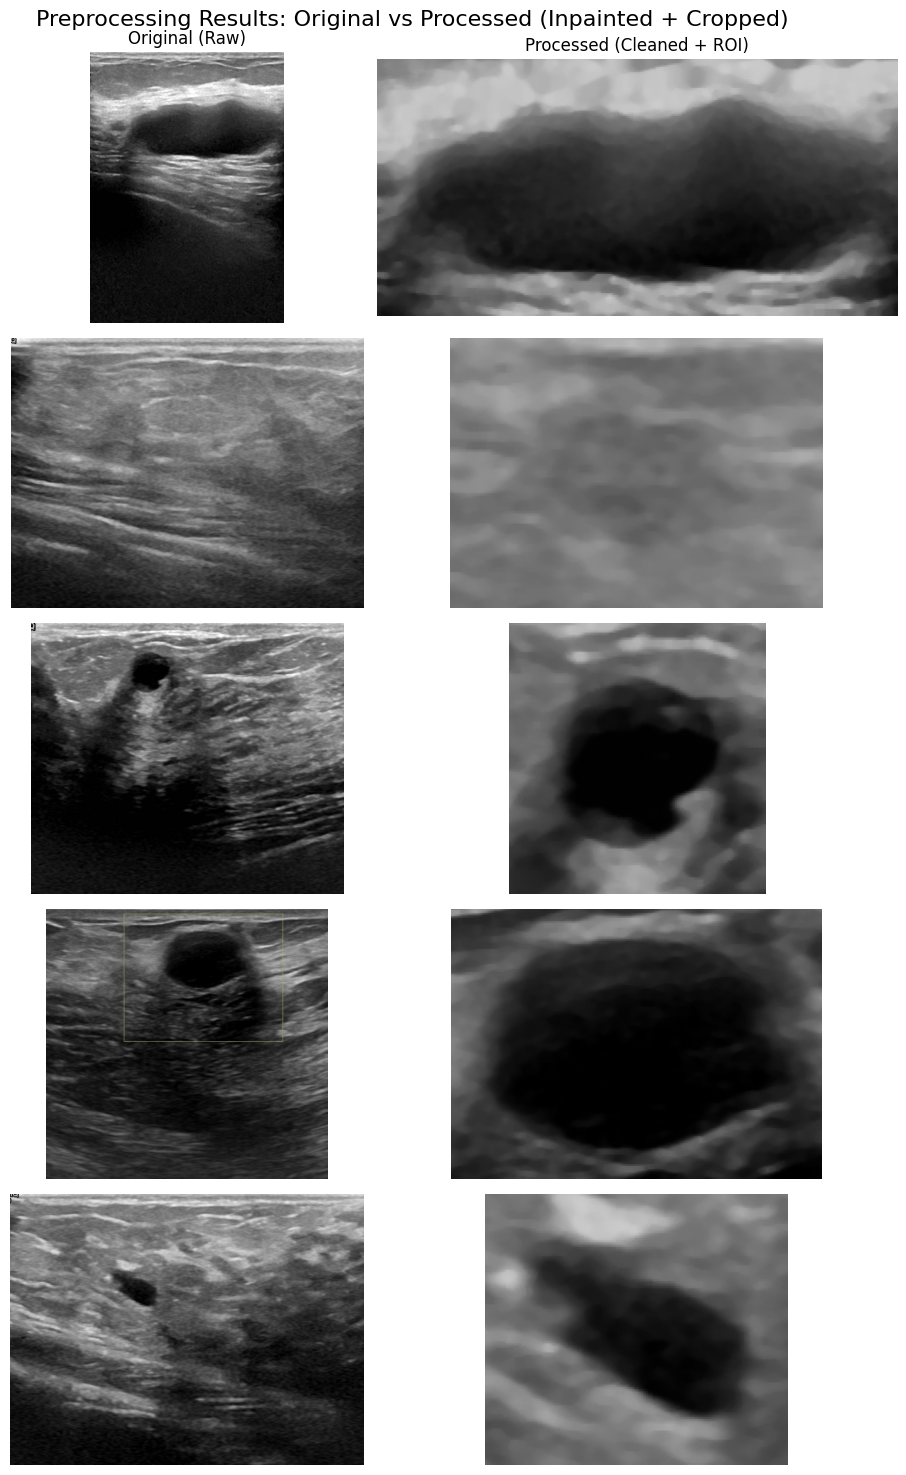

Preprocessing Complete.


In [ ]:
# Reproducibility
tf.random.set_seed(SEED)
np.random.seed(SEED)

def preprocess_and_save_images(source_dir, target_dir):
    """
    Iterates through BUSI data.
    1. Removes Text/Markers (Inpainting).
    2. Reduces Speckle Noise (Median Blur).
    3. Crops to Tumor ROI (using GT masks).
    4. Saves to a new directory.
    5. Displays a comparison of the first 5 images.
    """
    if not os.path.exists(target_dir):
        os.makedirs(target_dir)

    data_records = [] # To store file paths and labels
    visual_samples = [] # Store pairs of (original, processed) for visualization

    print("Starting Preprocessing... (This may take a moment)")

    classes = ['benign', 'malignant', 'normal']

    for class_name in classes:
        class_path = os.path.join(source_dir, class_name)
        save_path = os.path.join(target_dir, class_name)
        os.makedirs(save_path, exist_ok=True)

        if not os.path.exists(class_path):
            continue

        files = os.listdir(class_path)
        # Filter for original images only (not masks)
        image_files = [f for f in files if 'mask' not in f]

        for img_file in image_files:
            img_path = os.path.join(class_path, img_file)

            img = cv2.imread(img_path)
            if img is None: continue

            # Keep a copy of the original for visualization (Convert BGR to RGB)
            original_viz = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) if len(visual_samples) < 5 else None

            # 1. Processing: Remove Artifacts
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            _, artifact_mask = cv2.threshold(gray, 210, 255, cv2.THRESH_BINARY)
            kernel = np.ones((3,3), np.uint8)
            artifact_mask = cv2.dilate(artifact_mask, kernel, iterations=1)
            clean_img = cv2.inpaint(img, artifact_mask, 3, cv2.INPAINT_NS)

            # 2. Processing: Denoise
            clean_img = cv2.medianBlur(clean_img, 5)

            # 3. Processing: Crop ROI
            mask_name = img_file.replace('.png', '_mask.png')
            mask_path = os.path.join(class_path, mask_name)

            final_img = clean_img

            if os.path.exists(mask_path):
                gt_mask = cv2.imread(mask_path, 0)
                if gt_mask is not None:
                    contours, _ = cv2.findContours(gt_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
                    if contours:
                        c = max(contours, key=cv2.contourArea)
                        x, y, w, h = cv2.boundingRect(c)

                        pad = 20
                        h_img, w_img = clean_img.shape[:2]
                        x1 = max(0, x - pad)
                        y1 = max(0, y - pad)
                        x2 = min(w_img, x + w + pad)
                        y2 = min(h_img, y + h + pad)

                        final_img = clean_img[y1:y2, x1:x2]

            if len(visual_samples) < 5:
                # Convert processed image to RGB for matplotlib
                processed_viz = cv2.cvtColor(final_img, cv2.COLOR_BGR2RGB)
                visual_samples.append((original_viz, processed_viz))

            # Save
            save_file_path = os.path.join(save_path, img_file)
            cv2.imwrite(save_file_path, final_img)

            data_records.append({
                'filename': save_file_path,
                'class': class_name
            })

    print("Generating Comparison Panel...")
    fig, axes = plt.subplots(5, 2, figsize=(10, 15))
    fig.suptitle('Preprocessing Results: Original vs Processed (Inpainted + Cropped)', fontsize=16)

    for i, (orig, proc) in enumerate(visual_samples):
        # Plot Original
        axes[i, 0].imshow(orig)
        axes[i, 0].axis('off')
        if i == 0: axes[i, 0].set_title("Original (Raw)", fontsize=12)

        # Plot Processed
        axes[i, 1].imshow(proc)
        axes[i, 1].axis('off')
        if i == 0: axes[i, 1].set_title("Processed (Cleaned + ROI)", fontsize=12)

    plt.tight_layout()
    plt.show()

    print("Preprocessing Complete.")
    return pd.DataFrame(data_records)

# Run the cleaning
df = preprocess_and_save_images(SOURCE_DIR, PROCESSED_DIR)

In [ ]:
# STRATIFIED SPLITTING & DATA LOADERS
train_df, val_df = train_test_split(
    df,
    test_size=0.2,
    stratify=df['class'],
    random_state=SEED
)

print(f"Training Samples: {len(train_df)}")
print(f"Validation Samples: {len(val_df)}")

# Heavy Augmentation for Small Data
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='filename',
    y_col='class',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)

val_generator = val_datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col='filename',
    y_col='class',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

# Calculate Class Weights (to handle imbalance)
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)
class_weights_dict = dict(enumerate(class_weights))
print("Class Weights:", class_weights_dict)

Training Samples: 610
Validation Samples: 153
Found 610 validated image filenames belonging to 3 classes.
Found 153 validated image filenames belonging to 3 classes.
Class Weights: {0: np.float64(0.5826170009551098), 1: np.float64(1.2103174603174602), 2: np.float64(2.186379928315412)}


In [ ]:
class Patches(layers.Layer):
    def __init__(self, patch_size, **kwargs):
        super().__init__(**kwargs)
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim, **kwargs):
        super().__init__(**kwargs)
        self.num_patches = num_patches
        self.projection = layers.Dense(projection_dim)
        self.position_embedding = layers.Embedding(input_dim=num_patches, output_dim=projection_dim)

    def call(self, patchs):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patchs) + self.position_embedding(positions)
        return encoded

def build_vit_classifier(input_shape, num_classes,
                         patch_size=16, projection_dim=256,
                         transformer_layers=8, num_heads=8, mlp_dim=512,
                         dropout=0.1):
    inputs = layers.Input(shape=input_shape)

    x = layers.Rescaling(1./255)(inputs)

    # Patches
    patches = Patches(patch_size)(x)
    num_patches = (input_shape[0] // patch_size) * (input_shape[1] // patch_size)
    x = PatchEncoder(num_patches, projection_dim)(patches)

    # Transformer blocks
    for _ in range(transformer_layers):
        # LayerNorm + MHA
        x1 = layers.LayerNormalization(epsilon=1e-6)(x)
        attn = layers.MultiHeadAttention(num_heads=num_heads, key_dim=projection_dim, dropout=dropout)(x1, x1)
        x2 = layers.Add()([attn, x])

        # LayerNorm + MLP
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        mlp = layers.Dense(mlp_dim, activation="gelu")(x3)
        mlp = layers.Dropout(dropout)(mlp)
        mlp = layers.Dense(projection_dim)(mlp)
        x = layers.Add()([mlp, x2])

    # Head
    x = layers.LayerNormalization(epsilon=1e-6)(x)
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)

    return models.Model(inputs, outputs, name="ViT")

In [ ]:
def build_model(architecture_name):
    input_shape = (IMG_SIZE[0], IMG_SIZE[1], 3)
    NUM_CLASSES = 3
    if architecture_name == 'DenseNet121':
        base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=input_shape)

    elif architecture_name == 'DenseNet201':
        base_model = DenseNet201(weights='imagenet', include_top=False, input_shape=input_shape)

    elif architecture_name == 'ResNet50':
        base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)

    elif architecture_name == 'EfficientNetB0':
        base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=input_shape)

    elif architecture_name == 'ViT':
        model = build_vit_classifier(input_shape, NUM_CLASSES)
        model.compile(
            optimizer=optimizers.Adam(learning_rate=1e-4),
            loss='categorical_crossentropy',
            metrics=['accuracy']
        )
        return model

    else:
        raise ValueError("Unknown Architecture")

    # Freeze base model initially (classic transfer learning)
    base_model.trainable = False

    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.BatchNormalization(),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(NUM_CLASSES, activation='softmax')
    ])

    model.compile(
        optimizer=optimizers.Adam(learning_rate=1e-4),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model


Training DenseNet121...
29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 611ms/step - accuracy: 0.3435 - loss: 1.2631
Epoch 1: val_accuracy improved from -inf to 0.58170, saving model to checkpoints/DenseNet121_best.weights.h5
39/39 ━━━━━━━━━━━━━━━━━━━━ 77s 1s/step - accuracy: 0.3464 - loss: 1.2584 - val_accuracy: 0.5817 - val_loss: 0.8571 - learning_rate: 1.0000e-04
Epoch 2/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 286ms/step - accuracy: 0.6470 - loss: 0.7426
Epoch 2: val_accuracy improved from 0.58170 to 0.64052, saving model to checkpoints/DenseNet121_best.weights.h5
39/39 ━━━━━━━━━━━━━━━━━━━━ 14s 347ms/step - accuracy: 0.6476 - loss: 0.7418 - val_accuracy: 0.6405 - val_loss: 0.7436 - learning_rate: 1.0000e-04
Epoch 3/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step - accuracy: 0.6970 - loss: 0.5855
Epoch 3: val_accuracy improved from 0.64052 to 0.74510, saving model to checkpoints/DenseNet121_best.weights.h5
39/39 ━━━━━━━━━━━━━━━━━━━━ 13s 342ms/step - accuracy: 0.6976 - loss: 0.5848 - val_accuracy: 0.7451 - val_loss: 0.6531 - 

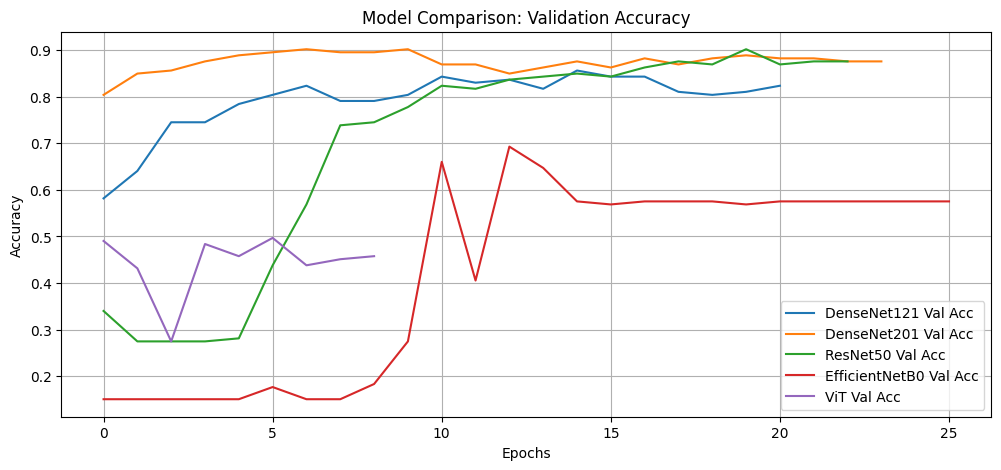


=== Comparison (sorted by max_val_acc) ===
            model    params  best_epoch  max_val_acc  \
1     DenseNet201  18822211           7     0.901961   
2        ResNet50  24121219          20     0.901961   
0     DenseNet121   7304771          15     0.856209   
3  EfficientNetB0   4383398          13     0.692810   
4             ViT  19188227           6     0.496732   

   eval_val_acc_after_reload  eval_val_loss_after_reload  
1                   0.901961                    0.385116  
2                   0.901961                    0.422285  
0                   0.856209                    0.348836  
3                   0.692810                    1.092464  
4                   0.496732                    1.025998  


In [ ]:
model_names = ['DenseNet121', 'DenseNet201', 'ResNet50', 'EfficientNetB0', 'ViT']

history_dict = {}
trained_models = {}
best_ckpt_paths = {}
results_rows = []

os.makedirs("checkpoints", exist_ok=True)
os.makedirs("saved_models", exist_ok=True)

plt.figure(figsize=(12, 5))

for model_name in model_names:
    print(f"\nTraining {model_name}...")
    model = build_model(model_name)

    ckpt_path = f"checkpoints/{model_name}_best.weights.h5"
    best_ckpt_paths[model_name] = ckpt_path

    early_stop = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=False,
        verbose=1
    )

    ckpt = tf.keras.callbacks.ModelCheckpoint(
        ckpt_path,
        monitor="val_accuracy",
        mode="max",
        save_best_only=True,
        save_weights_only=True,
        verbose=1
    )

    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss",
        factor=0.5,
        patience=2,
        min_lr=1e-7,
        verbose=1
    )

    history = model.fit(
        train_generator,
        epochs=EPOCHS,
        validation_data=val_generator,
        class_weight=class_weights_dict,
        callbacks=[ckpt, early_stop, reduce_lr],
        verbose=1
    )

    # Load best weights for evaluation + later fine-tuning
    model.load_weights(ckpt_path)

    history_dict[model_name] = history
    trained_models[model_name] = model

    # Plot val accuracy curve
    plt.plot(history.history['val_accuracy'], label=f'{model_name} Val Acc')

    # Summaries for comparison table
    val_acc_hist = history.history['val_accuracy']
    best_epoch = int(np.argmax(val_acc_hist)) + 1
    max_val_acc = float(np.max(val_acc_hist))

    eval_loss, eval_acc = model.evaluate(val_generator, verbose=0)
    params = model.count_params()

    results_rows.append({
        "model": model_name,
        "params": params,
        "best_epoch": best_epoch,
        "max_val_acc": max_val_acc,
        "eval_val_acc_after_reload": float(eval_acc),
        "eval_val_loss_after_reload": float(eval_loss),
        "ckpt_path": ckpt_path
    })

plt.title('Model Comparison: Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

results_df = pd.DataFrame(results_rows).sort_values("max_val_acc", ascending=False)
print("\n=== Comparison (sorted by max_val_acc) ===")
print(results_df[["model","params","best_epoch","max_val_acc","eval_val_acc_after_reload","eval_val_loss_after_reload"]])

In [ ]:
# Identify the best model based on max validation accuracy
best_row = results_df.iloc[0]
best_model_name = best_row["model"]
best_ckpt = best_row["ckpt_path"]

print(f"\nBest Model: {best_model_name} with max Val Accuracy: {best_row['max_val_acc']:.4f}")

best_model = trained_models[best_model_name]

best_model.load_weights(best_ckpt)

def freeze_batchnorm(m):
    for layer in m.layers:
        if isinstance(layer, tf.keras.Model):
            freeze_batchnorm(layer)
        if isinstance(layer, layers.BatchNormalization):
            layer.trainable = False

def unfreeze_last_n_layers(base_model, n):
    # base_model is the backbone (for Sequential models it's layer 0)
    base_model.trainable = True
    if n is None:
        # unfreeze everything (except BN handled separately)
        for l in base_model.layers:
            l.trainable = True
    else:
        for l in base_model.layers[:-n]:
            l.trainable = False
        for l in base_model.layers[-n:]:
            l.trainable = True

# Fine-tune callbacks
fine_early_stop = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=4, restore_best_weights=True, verbose=1
)
fine_reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss", factor=0.5, patience=2, min_lr=1e-7, verbose=1
)

# If it's ViT, we fine-tune end-to-end (it is already end-to-end)
if best_model_name == "ViT":
    print("\nFine-tuning ViT end-to-end from best checkpoint...")

    best_model.compile(
        optimizer=optimizers.Adam(learning_rate=5e-6),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    history_fine = best_model.fit(
        train_generator,
        epochs=12,
        validation_data=val_generator,
        class_weight=class_weights_dict,
        callbacks=[fine_early_stop, fine_reduce_lr],
        verbose=1
    )

else:
    backbone = best_model.layers[0]

    print(f"\nFine-tuning {best_model_name} Stage A (unfreeze top layers, BN frozen) from best checkpoint...")
    unfreeze_last_n_layers(backbone, n=40)  # adjust 20/40/80 depending on dataset size
    freeze_batchnorm(backbone)

    best_model.compile(
        optimizer=optimizers.Adam(learning_rate=1e-5),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    history_fine_a = best_model.fit(
        train_generator,
        epochs=8,
        validation_data=val_generator,
        class_weight=class_weights_dict,
        callbacks=[fine_early_stop, fine_reduce_lr],
        verbose=1
    )

    print(f"\nFine-tuning {best_model_name} Stage B (unfreeze ALL, BN frozen) ...")
    unfreeze_last_n_layers(backbone, n=None)  # all trainable
    freeze_batchnorm(backbone)

    best_model.compile(
        optimizer=optimizers.Adam(learning_rate=3e-6),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    history_fine_b = best_model.fit(
        train_generator,
        epochs=10,
        validation_data=val_generator,
        class_weight=class_weights_dict,
        callbacks=[fine_early_stop, fine_reduce_lr],
        verbose=1
    )

    # Merge fine histories for reporting
    history_fine = history_fine_a
    for k in history_fine.history.keys():
        history_fine.history[k] = history_fine_a.history[k] + history_fine_b.history[k]

# Final eval
loss, accuracy = best_model.evaluate(val_generator, verbose=1)
print(f"\nFinal Fine-tuned Loss: {loss:.4f}")
print(f"Final Fine-tuned Accuracy: {accuracy:.4f}")


Best Model: DenseNet201 with max Val Accuracy: 0.9020

Fine-tuning DenseNet201 Stage A (unfreeze top layers, BN frozen) from best checkpoint...
Epoch 1/8
39/39 ━━━━━━━━━━━━━━━━━━━━ 126s 2s/step - accuracy: 0.7786 - loss: 0.4172 - val_accuracy: 0.8954 - val_loss: 0.3701 - learning_rate: 1.0000e-05
Epoch 2/8
39/39 ━━━━━━━━━━━━━━━━━━━━ 13s 337ms/step - accuracy: 0.8300 - loss: 0.3553 - val_accuracy: 0.8889 - val_loss: 0.3578 - learning_rate: 1.0000e-05
Epoch 3/8
39/39 ━━━━━━━━━━━━━━━━━━━━ 13s 335ms/step - accuracy: 0.8362 - loss: 0.3915 - val_accuracy: 0.8954 - val_loss: 0.3467 - learning_rate: 1.0000e-05
Epoch 4/8
39/39 ━━━━━━━━━━━━━━━━━━━━ 13s 331ms/step - accuracy: 0.8045 - loss: 0.4121 - val_accuracy: 0.8954 - val_loss: 0.3400 - learning_rate: 1.0000e-05
Epoch 5/8
39/39 ━━━━━━━━━━━━━━━━━━━━ 13s 337ms/step - accuracy: 0.8333 - loss: 0.3488 - val_accuracy: 0.8889 - val_loss: 0.3368 - learning_rate: 1.0000e-05
Epoch 6/8
39/39 ━━━━━━━━━━━━━━━━━━━━ 13s 335ms/step - accuracy: 0.8182 - loss

In [ ]:
results_df = results_df.copy()
results_df["fine_tuned_val_acc"] = np.nan
results_df.loc[results_df["model"] == best_model_name, "fine_tuned_val_acc"] = float(accuracy)
results_df.to_csv('Final Results.csv')

print("\n=== Final Results (including fine-tuned best model) ===")
print(results_df[["model","params","max_val_acc","eval_val_acc_after_reload","fine_tuned_val_acc"]]
      .sort_values(["fine_tuned_val_acc","max_val_acc"], ascending=False))


=== Final Results (including fine-tuned best model) ===
            model    params  max_val_acc  eval_val_acc_after_reload  \
1     DenseNet201  18822211     0.901961                   0.901961   
2        ResNet50  24121219     0.901961                   0.901961   
0     DenseNet121   7304771     0.856209                   0.856209   
3  EfficientNetB0   4383398     0.692810                   0.692810   
4             ViT  19188227     0.496732                   0.496732   

   fine_tuned_val_acc  
1            0.901961  
2                 NaN  
0                 NaN  
3                 NaN  
4                 NaN  
